# Unbalanced Optimal Transport


This tutorial shows how to use `OTT` to compute the solution of an unbalanced optimal transport (OT) problem using the Sinkhorn algorithm. The unbalanced OT problem with an entropic regularization is defined as : 
$$\arg \min_{P>0} \langle P,C \rangle - \varepsilon \text{KL}(P|ab^T) + \rho_a \text{KL}(P\textbf{1}_m|a) + \rho_b \text{KL}(P^T\textbf{1}_n|b)$$
where $\rho_a$ and $\rho_b$ regularize a discrepancy with respect to marginal constraints and $\varepsilon$ accounts for the entropic regularization.
The algorithm used to solve the unbalanced OT problem is {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm whose steps are detailed in {cite}`NIPS2015_a9eb8122`.
Instead of $\rho_a$ and $\rho_b$, `OTT`'s solver uses parameters `tau_a`$=\rho_a /(\varepsilon+ \rho_a)$ and `tau_b`$=\rho_b /(\varepsilon+ \rho_b)$. Setting either of these parameters to 1 corresponds to setting the corresponding $\rho_a, \rho_b$ to $\infty$ and solving the corresponding balanced {class}`~ott.problems.linear.linear_problem.LinearProblem`. 

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot
from ott.tools.gaussian_mixture import gaussian_mixture, probabilities

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Generate source and target distributions

Let us first generate the source and target distributions that correspond to the illustrative exemple of {cite}`sejourne:23` (Figure 4). The corresponding plots can be visualized below.  

In [2]:
rng = jax.random.PRNGKey(0)
rng_source, rng = jax.random.split(rng, 2)
means_source = jnp.array(
    [
        [-1.6, -1.6],
        [-1, 0.25],
        [0.25, -1],
        [0.25, 1],
        [1, 0.25],
    ]
)
cov_source = jnp.array([0.01 * jnp.identity(2)] * 5)
weight_source = jnp.array([1 / 5] * 5)
source_GMM = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
    mean=means_source,
    cov=cov_source,
    component_weights=weight_source,
)
n_samples_source = 40
x = source_GMM.sample(rng_source, n_samples_source)

rng_target, rng = jax.random.split(rng, 2)
means_target = jnp.array(
    [
        [1.6, 1.6],
        [-1, -0.25],
        [-0.25, -1],
        [-0.25, 1],
        [1, -0.25],
    ]
)
cov_target = jnp.array([0.01 * jnp.identity(2)] * 5)
weight_target = jnp.array([1 / 5] * 5)


target_GMM = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
    mean=means_target,
    cov=cov_target,
    component_weights=weight_target,
)
n_samples_target = 42
y = target_GMM.sample(rng_target, n_samples_target)

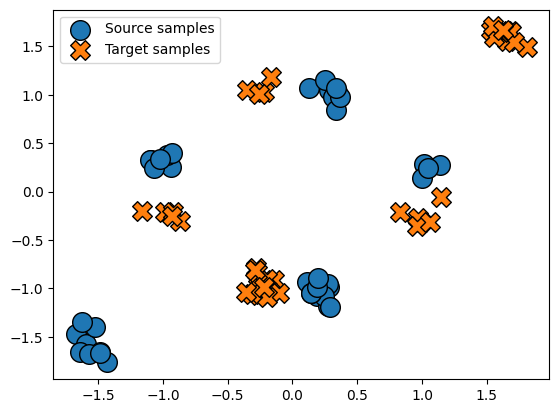

In [3]:
plt.scatter(
    x[:, 0],
    x[:, 1],
    s=200,
    edgecolors="k",
    marker="o",
    label="Source samples",
)
plt.scatter(
    y[:, 0],
    y[:, 1],
    s=200,
    edgecolors="k",
    marker="X",
    label="Target samples",
)
plt.legend()
plt.show()

The source and target distributions are both a mixture of five gaussians. One can observe that the central four modes from the source can be naturally matched to the central four modes from the target while in each distribution the fifth mode is distant and can be seen as outliers.

Let us first visualize the result of the balanced OT in this setting.

## Balanced OT mapping

Solving the balanced OT problem is equivalent to fixing `tau_a`=`tau_b`=`1.0`.

In [4]:
# Define an euclidean geometry with epsilon=0.001
geom = pointcloud.PointCloud(x, y, epsilon=0.001)

In [5]:
# Define a linear problem associated to the geometry defined above and tau_a = tau_b = 1.0
ot_prob = linear_problem.LinearProblem(geom, tau_a=1.0, tau_b=1.0)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)

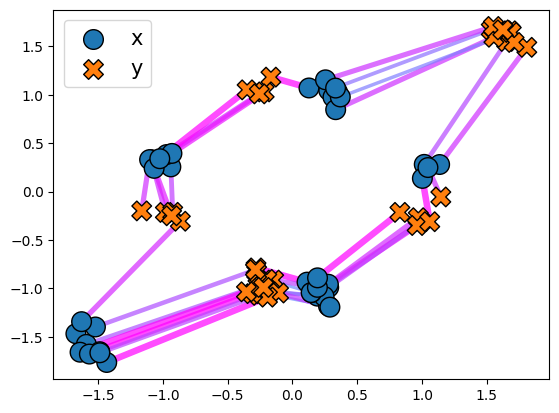

In [6]:
# Plot the computed transport plan
plott = plot.Plot(cost_threshold=1e-2)
_ = plott(ot)

In the solution of the balanced OT problem, the outliers interact with the other points. This is not suitable in several applications where only clusters that are closeby should interact. In the following, we will see that this mapping can be computed by solving the unbalanced OT problem.

## Unbalanced OT mapping

We will now define an unbalanced OT problem with `tau_a`=`tau_b`=`0.999`.

In [7]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom, tau_a=0.999, tau_b=0.999)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)

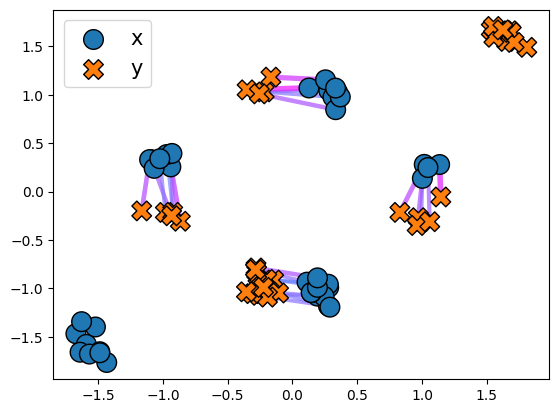

In [8]:
plott = plot.Plot(cost_threshold=1e-2)
_ = plott(ot)

This is the most natural solution : in this setting only clusters that are close to each other interact.